In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from tslearn.clustering import TimeSeriesKMeans

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
fp_p = '/Users/alexbruefach/Documents/GitHub/DSproject-covid-stress-impact/covid-policy-region/OxCGRT_latest.csv'
data_p = pd.read_csv(fp_p)

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Policy Data Cleaning and Clustering

In [3]:
data_p = data_p[data_p['CountryCode']=='USA']
data_p = data_p.dropna(subset=['RegionName'])
data_p['Datetime'] = pd.to_datetime(data_p['Date'], format='%Y%m%d')
data_p = data_p[(data_p['Datetime']<pd.Timestamp(2021,6,1)) & (data_p['Datetime']>pd.Timestamp(2020,12,1))]

In [4]:
data_vacpol_usa = data_p[['RegionName', 'H7_Vaccination policy', 'Datetime']]

In [5]:
df_states = data_vacpol_usa.pivot(index='RegionName', columns='Datetime')['H7_Vaccination policy']
df_states = df_states.dropna(axis='columns')

In [6]:
states = data_p['RegionName'].unique()

In [7]:
from scipy.spatial import distance_matrix
df = df_states
X = pd.DataFrame(distance_matrix(df.values, df.values, p=1), 
                 index=df.index, columns=df.index)

In [38]:
n_clusters = 6
gmm = GaussianMixture(n_components = n_clusters, covariance_type = 'full')
gmm_labels =gmm.fit_predict(X)

dict_stategroups = dict(zip(states,gmm_labels))
state_groups = [list(df_states.index[gmm_labels == i]) for i in range(n_clusters)]

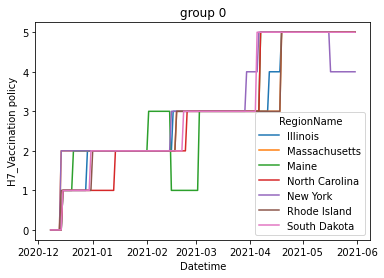

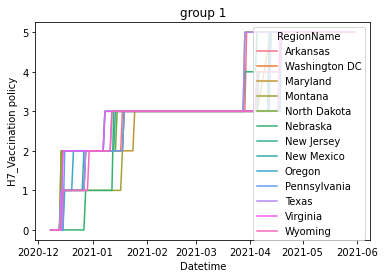

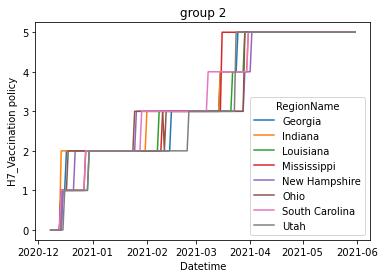

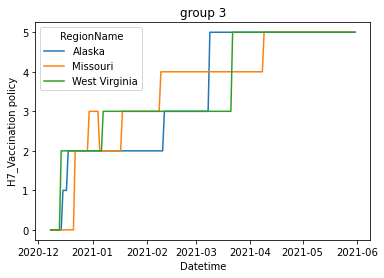

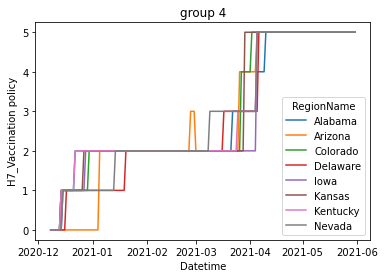

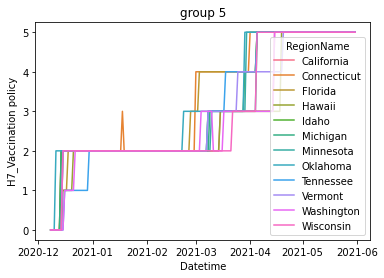

In [70]:
for i in range(n_clusters):
    data_onereg = data_p[data_p['RegionName'].isin(state_groups[i])]
    sns.lineplot(data=data_onereg, x='Datetime', y='H7_Vaccination policy', hue="RegionName")
    plt.title('group ' + str(i))
    plt.show()

In [99]:
## Save state dictionary
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [100]:
#save_obj(dict_stategroups, 'state_labels_10.17.21_classes=6')

## Stress dataset

In [10]:
fp_s = '/Users/alexbruefach/Documents/GitHub/DSproject-covid-stress-impact/covid19tracker_recoded.csv'
data_s = pd.read_csv(fp_s, encoding='latin-1')

/Users/alexbruefach/opt/anaconda3/envs/ds4aw/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (390,391,392,393,394,395,405,406) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
data_s['month'] = pd.DatetimeIndex(data_s.endtime).month
data_s['year'] = pd.DatetimeIndex(data_s.endtime).year
data_s['year-month'] = pd.to_datetime(data_s[['year', 'month']].assign(DAY=1))

In [73]:
data_s.keys()

Index(['ï..RecordNo', 'endtime', 'state', 'qweek', 'i1_health', 'i2_health',
       'i7a_health', 'i3_health', 'i4_health', 'i5_health_1',
       ...
       'child_education_4', 'childvac', 'combi_vac', 'employment_status.cat',
       'PHQ4_sum', 'child_education_sum', 'month', 'year', 'year-month',
       'state_labels'],
      dtype='object', length=414)

In [13]:
# states_dict = {'Alabama': 1, 'Alaska': 0, 'Arizona': 3, 'Arkansas': 2, 
#                'California': 1, 'Colorado': 3, 'Connecticut': 0, 'Delaware': 3, 
#                'Florida': 0, 'Georgia': 0, 'Hawaii': 1, 'Idaho': 1, 'Illinois': 1, 
#                'Indiana': 0, 'Iowa': 3, 'Kansas': 3, 'Kentucky': 1, 'Louisiana': 0, 
#                'Maine': 1, 'Maryland': 2, 'Massachusetts': 1, 'Michigan': 1, 'Minnesota': 1, 
#                'Mississippi': 0, 'Missouri': 0, 'Montana': 2, 'Nebraska': 2, 'Nevada': 1, 
#                'New Hampshire': 2, 'New Jersey': 2, 'New Mexico': 2, 'New York': 1, 
#                'North Carolina': 1, 'North Dakota': 2, 'Ohio': 2, 'Oklahoma': 1, 'Oregon': 2, 
#                'Pennsylvania': 2, 'Rhode Island': 1, 'South Carolina': 0, 'South Dakota': 1, 
#                'Tennessee': 1, 'Texas': 2, 'Utah': 1, 'Vermont': 1, 'Virginia': 2, 'Washington': 1, 
#                'Washington DC': 2, 'West Virginia': 2, 'Wisconsin': 1, 'Wyoming': 2}

In [50]:
data_s = data_s.replace('District of Columbia','Washington DC')

In [51]:
data_state_list = data_s['state'].tolist()
state_labels = [dict_stategroups[i] for i in data_state_list]

In [52]:
data_s['state_labels'] = state_labels

## Exploratory Data Analysis

In [53]:
data_stress_additive = data_s[['state_labels', 'PHQ4_sum']]

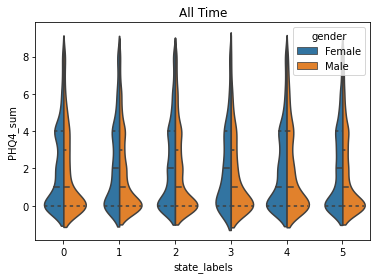

In [108]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', 
               hue = 'gender',
               split = True,
               data = data_s.sort_values('gender'),
               inner='quartile')
plt.title('All Time')
plt.show()

In [64]:
## Group by dates
data_s_pre = data_s[(data_s['year-month']<pd.Timestamp(2020,11,30)) & (data_s['year-month']>pd.Timestamp(2020,8,31))]
data_s_dur = data_s[(data_s['year-month']<pd.Timestamp(2021,4,30)) & (data_s['year-month']>pd.Timestamp(2020,12,31))]
data_s_pos = data_s[(data_s['year-month']>pd.Timestamp(2021,4,30)) & (data_s['year-month']>pd.Timestamp(2020,7,31))]

In [102]:
data_s_pre['PHQ4_sum'].value_counts()

0.0    792
4.0    306
2.0    293
1.0    247
3.0    217
5.0    131
6.0     92
7.0     51
8.0     51
Name: PHQ4_sum, dtype: int64

In [105]:
data_s_pre.groupby('state_labels')['PHQ4_sum'].count()

state_labels
0    283
1    386
2    581
3    105
4    293
5    532
Name: PHQ4_sum, dtype: int64

In [66]:
data_s_dur.groupby('state_labels')['PHQ4_sum'].count()

state_labels
0    188
1    212
2    358
3     77
4    186
5    331
Name: PHQ4_sum, dtype: int64

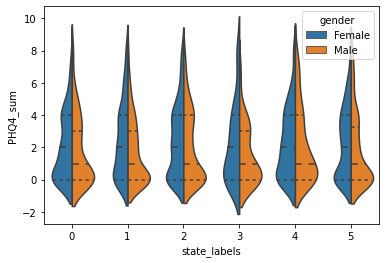

In [86]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', 
               hue = 'gender',
               split = True,
               data = data_s_pre.sort_values('gender'),
               inner='quartile')
plt.show()

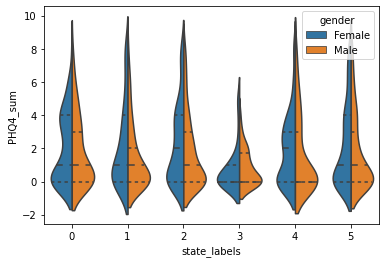

In [88]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum', 
               hue = 'gender',
               split = True,
               data = data_s_dur.sort_values('gender'), 
               inner='quartile')
plt.show()

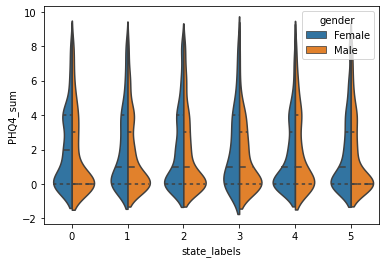

In [92]:
sns.violinplot(x = 'state_labels', y = 'PHQ4_sum',
               hue = 'gender',
               split = True,
               data = data_s_pos.sort_values('gender'),
              inner='quartile')
plt.show()